In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import matplotlib.ticker as tick
import stylecloud
import numpy as np

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

In [2]:
with wandb.init() as run:
    dan = run.use_artifact("yass/clinical-longformer-test/run-iazv60p9-test_table:v0").get("test_table")
    lstm = run.use_artifact("yass/clinical-longformer-test/run-1y0wf6kl-lstm_table:v0").get("lstm_table")
    bert = run.use_artifact('yass/clinical-longformer-test/run-ute5a294-bert_table:v0').get("bert_table")
    longf_1024 = run.use_artifact('yass/clinical-longformer-test/run-30hp2c54-longf1024_table:v0').get("longf-1024_table")
    longf_2048 = run.use_artifact('yass/clinical-longformer-test/run-2c9lt878-longf2048_table:v0').get("longf-2048_table")
    longf_4096 = run.use_artifact('yass/clinical-longformer-test/run-2nflkt4r-test_table:v0').get("test_table")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yass. Use `wandb login --relogin` to force relogin


In [3]:
df_dan = pd.DataFrame(dan.data, columns=dan.columns)
df_lstm = pd.DataFrame(lstm.data, columns=lstm.columns)
df_bert = pd.DataFrame(bert.data, columns=bert.columns)
df_longf_1024  = pd.DataFrame(longf_1024.data, columns=longf_1024.columns)
df_longf_2048  = pd.DataFrame(longf_2048.data, columns=longf_2048.columns)
df_longf_4096  = pd.DataFrame(longf_4096.data, columns=longf_4096.columns)

df_dan = df_dan.rename(columns={"pred": "p_readmit"})
df_lstm = df_lstm.rename(columns={"pred": "p_readmit"})
df_longf_4096 = df_longf_4096.rename(columns={"pred_y": "p_readmit"})

dfs = [
    ("DAN", df_dan.groupby("hadm_id").first().reset_index()),
    ("LSTM", df_lstm.groupby("hadm_id").first().reset_index()),
    ("BERT", df_bert.groupby("hadm_id").first().reset_index()),
    ("Longformer 1K", df_longf_1024.groupby("hadm_id").first().reset_index()),
    ("Longformer 2K", df_longf_2048.groupby("hadm_id").first().reset_index()),
    ("Longformer 4K", df_longf_4096.groupby("hadm_id").first().reset_index())
]

(array([ 82.,  45.,  32.,  27.,  33.,  35.,  42.,  32.,  56., 111.]),
 array([0.11102295, 0.18468628, 0.25834961, 0.33201294, 0.40567627,
        0.4793396 , 0.55300293, 0.62666626, 0.70032959, 0.77399292,
        0.84765625]),
 <BarContainer object of 10 artists>)

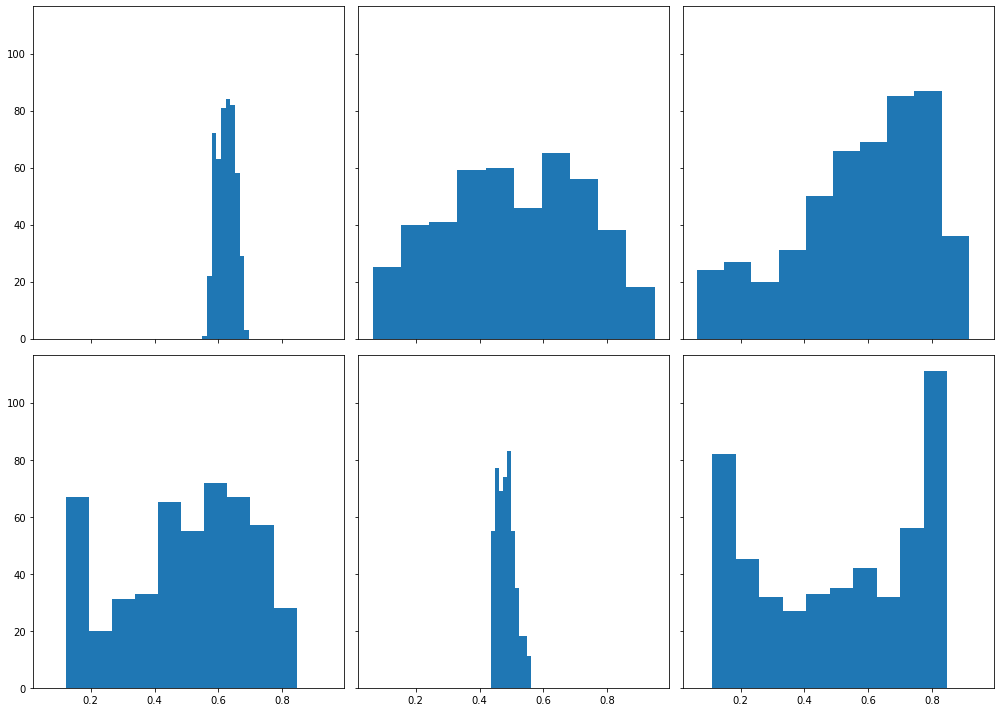

In [50]:
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(14, 10), sharey=True, sharex=True)
axs[0,0].hist(dfs[0][1].p_readmit)
axs[0,1].hist(dfs[1][1].p_readmit)
axs[0,2].hist(dfs[2][1].p_readmit)
axs[1,0].hist(dfs[3][1].p_readmit)
axs[1,1].hist(dfs[4][1].p_readmit)
axs[1,2].hist(dfs[5][1].p_readmit)

In [5]:
TEXT_SIZE = 800

# Precision-Recall Curve


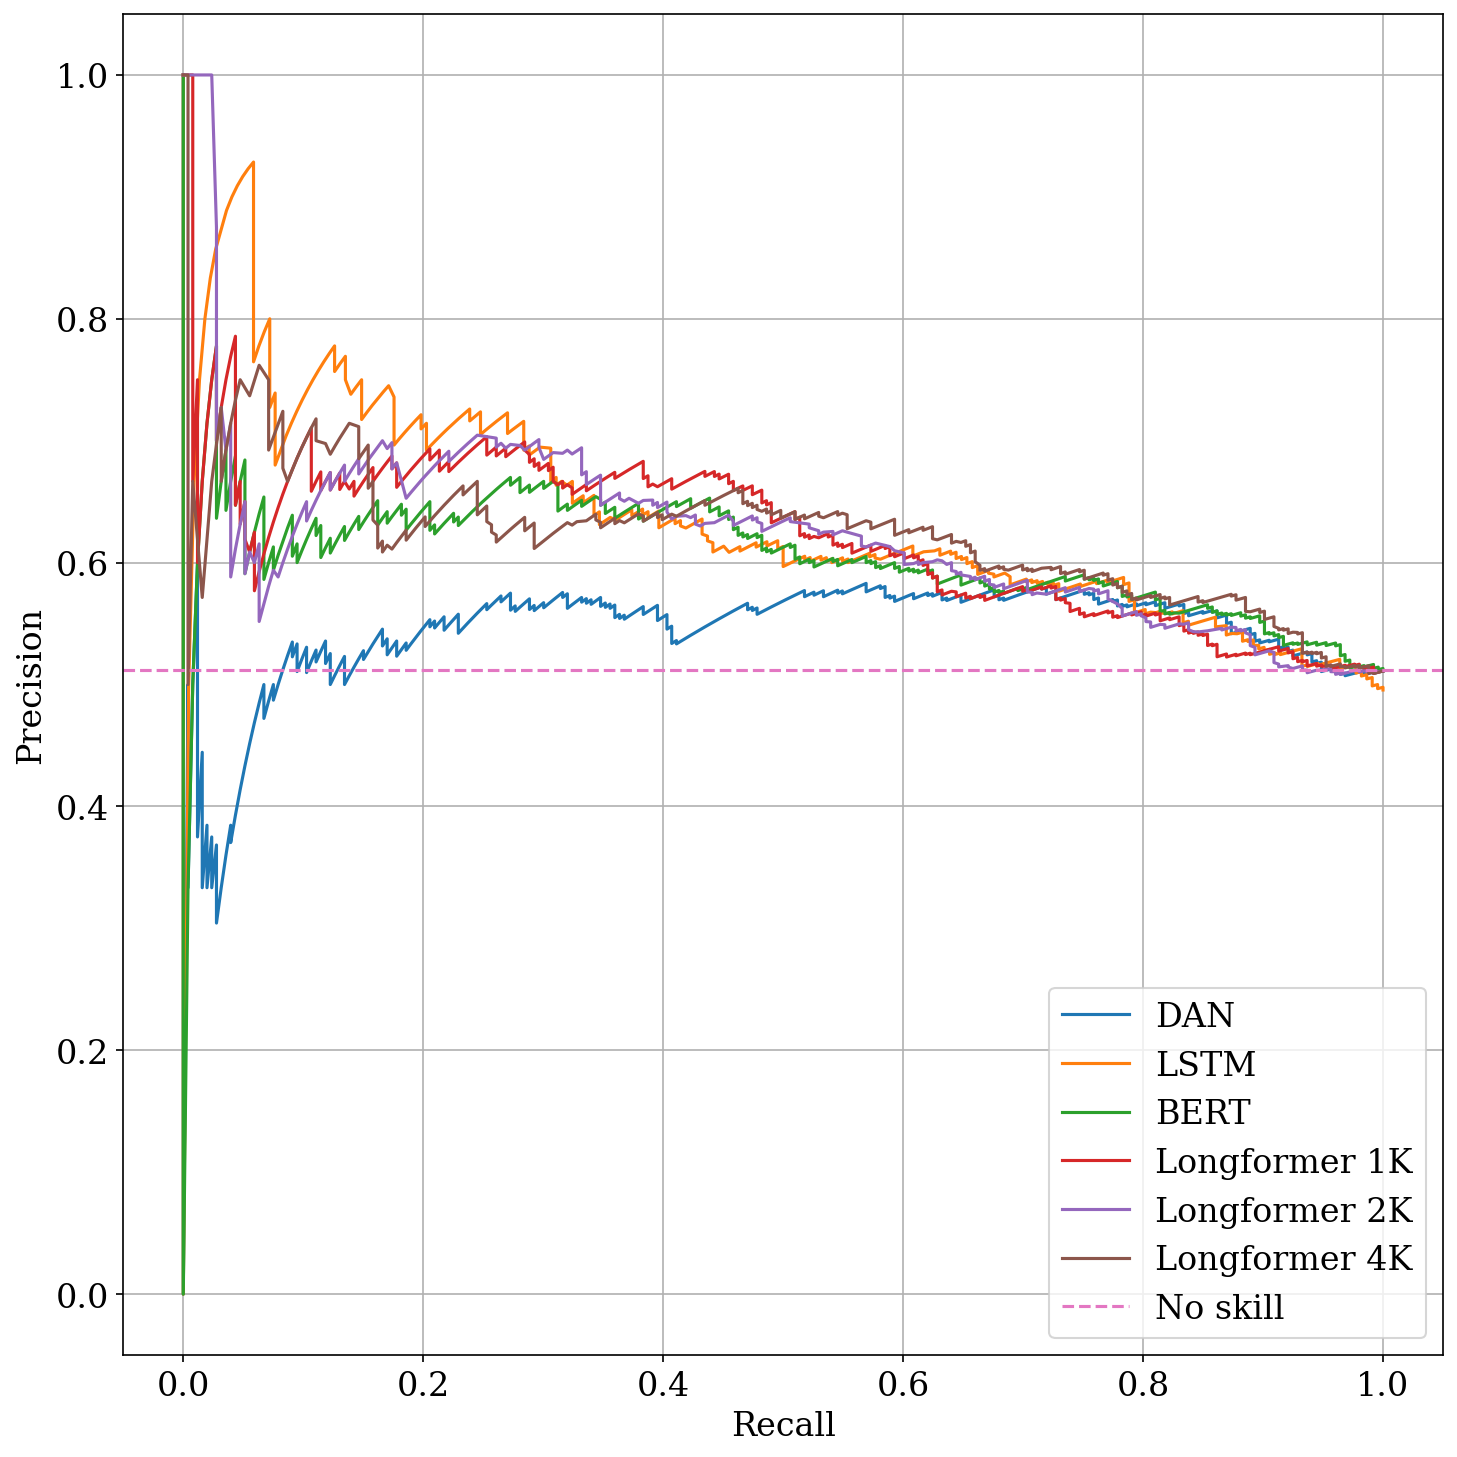

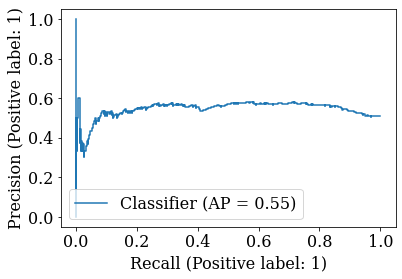

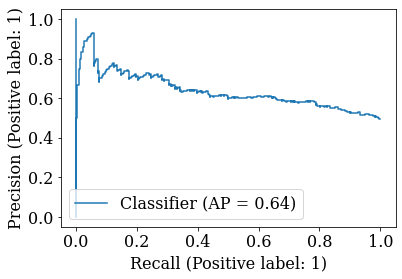

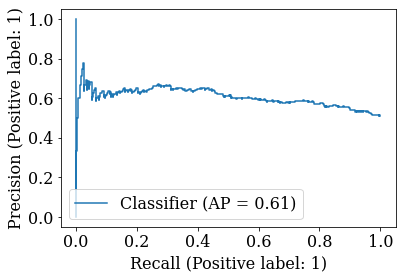

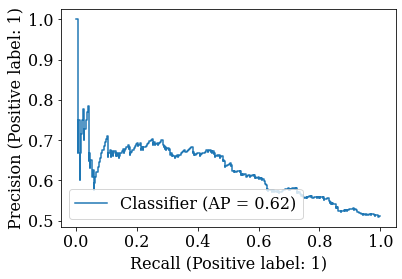

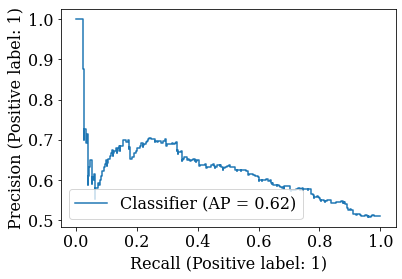

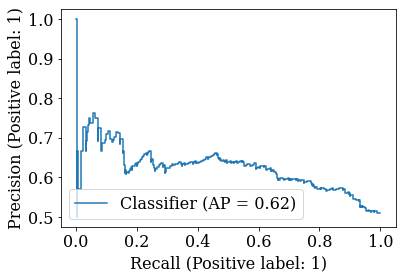

In [6]:
plt.rc('font', size=16, family=["Serif", "Palatino"])

df = dfs[0][1]
positives = len(df[df["target"] == 1]) / len(df)

fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
for (name, df) in dfs:
    display = PrecisionRecallDisplay.from_predictions(df.target, df.p_readmit)
    display.plot(ax=ax, name=name, drawstyle="default", label=name)

ax.plot([0, 1], [positives] * 2, linestyle='--', label="No skill", transform=ax.transAxes)
ax.set(xlabel="Recall", ylabel="Precision")
ax.legend(loc="lower right")
ax.grid(True)
fig.tight_layout()


# ROC Curve

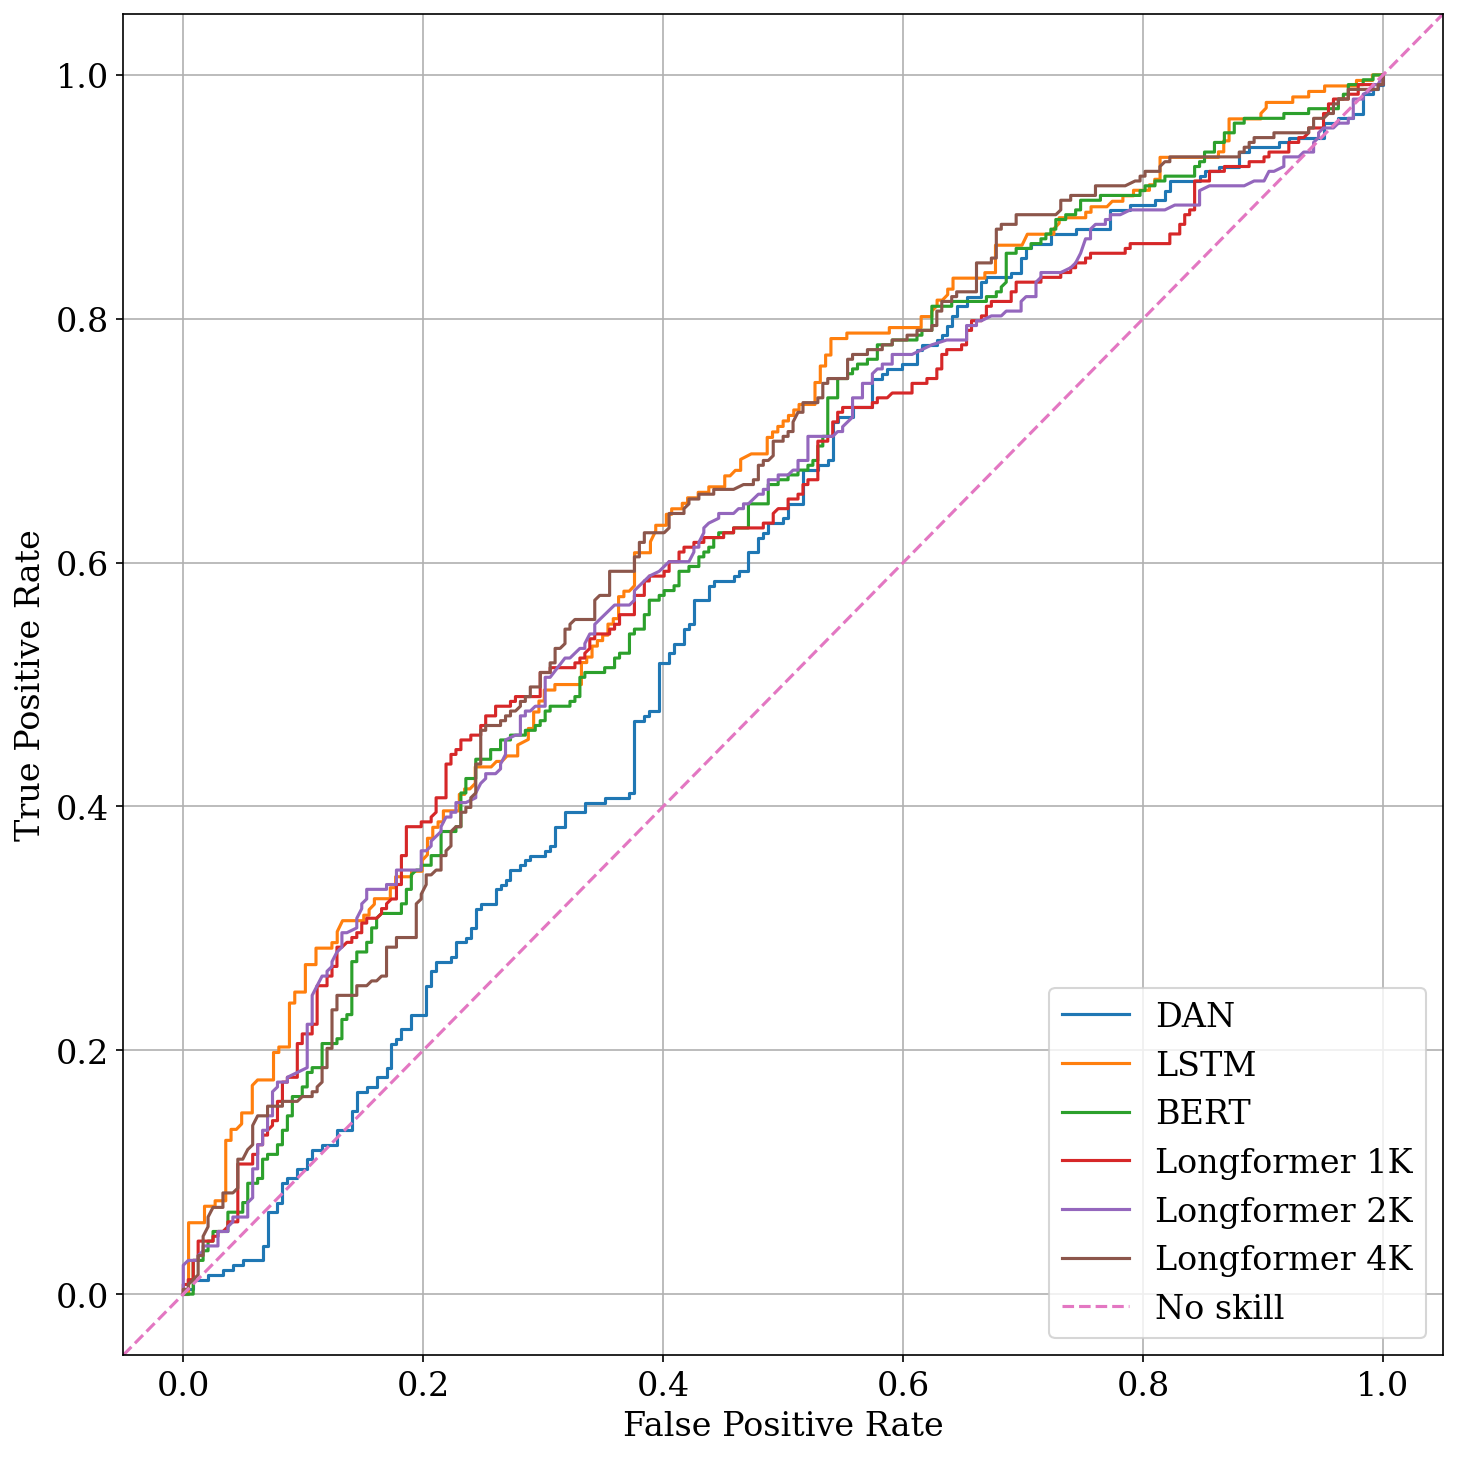

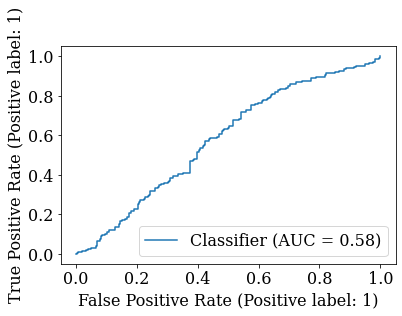

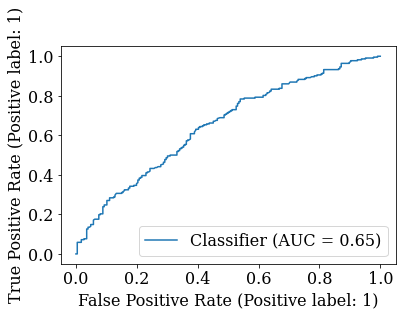

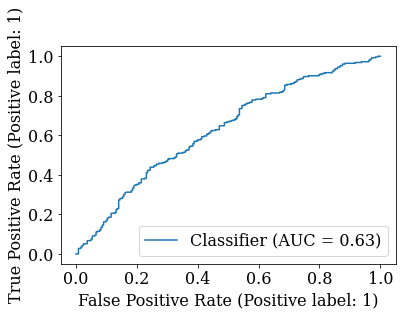

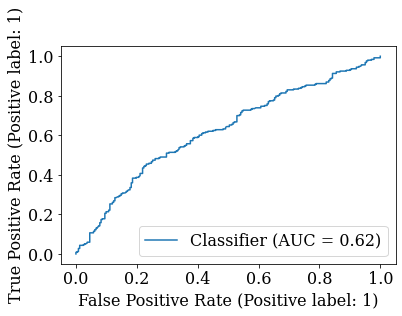

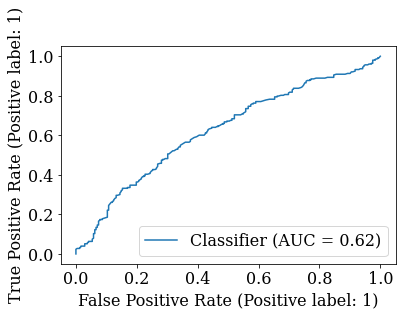

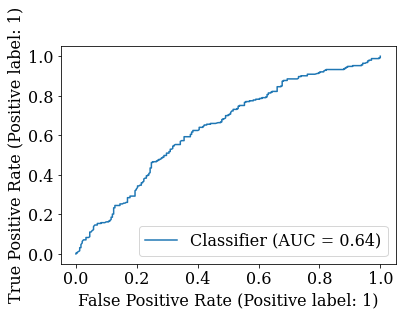

In [7]:
plt.rc('font', size=16, family=["Serif", "Palatino"])

df = dfs[0][1]
positives = len(df[df["target"] == 1]) / len(df)

fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
for (name, df) in dfs:
    display = RocCurveDisplay.from_predictions(df.target, df.p_readmit)
    display.plot(ax=ax, name=f"{name}", drawstyle="default", label=f"{name}")

ax.plot([0, 1], [0, 1], linestyle='--', label="No skill", transform=ax.transAxes)
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax.legend(loc="lower right")
ax.grid(True)
fig.tight_layout()

# Hyperparameter tuning

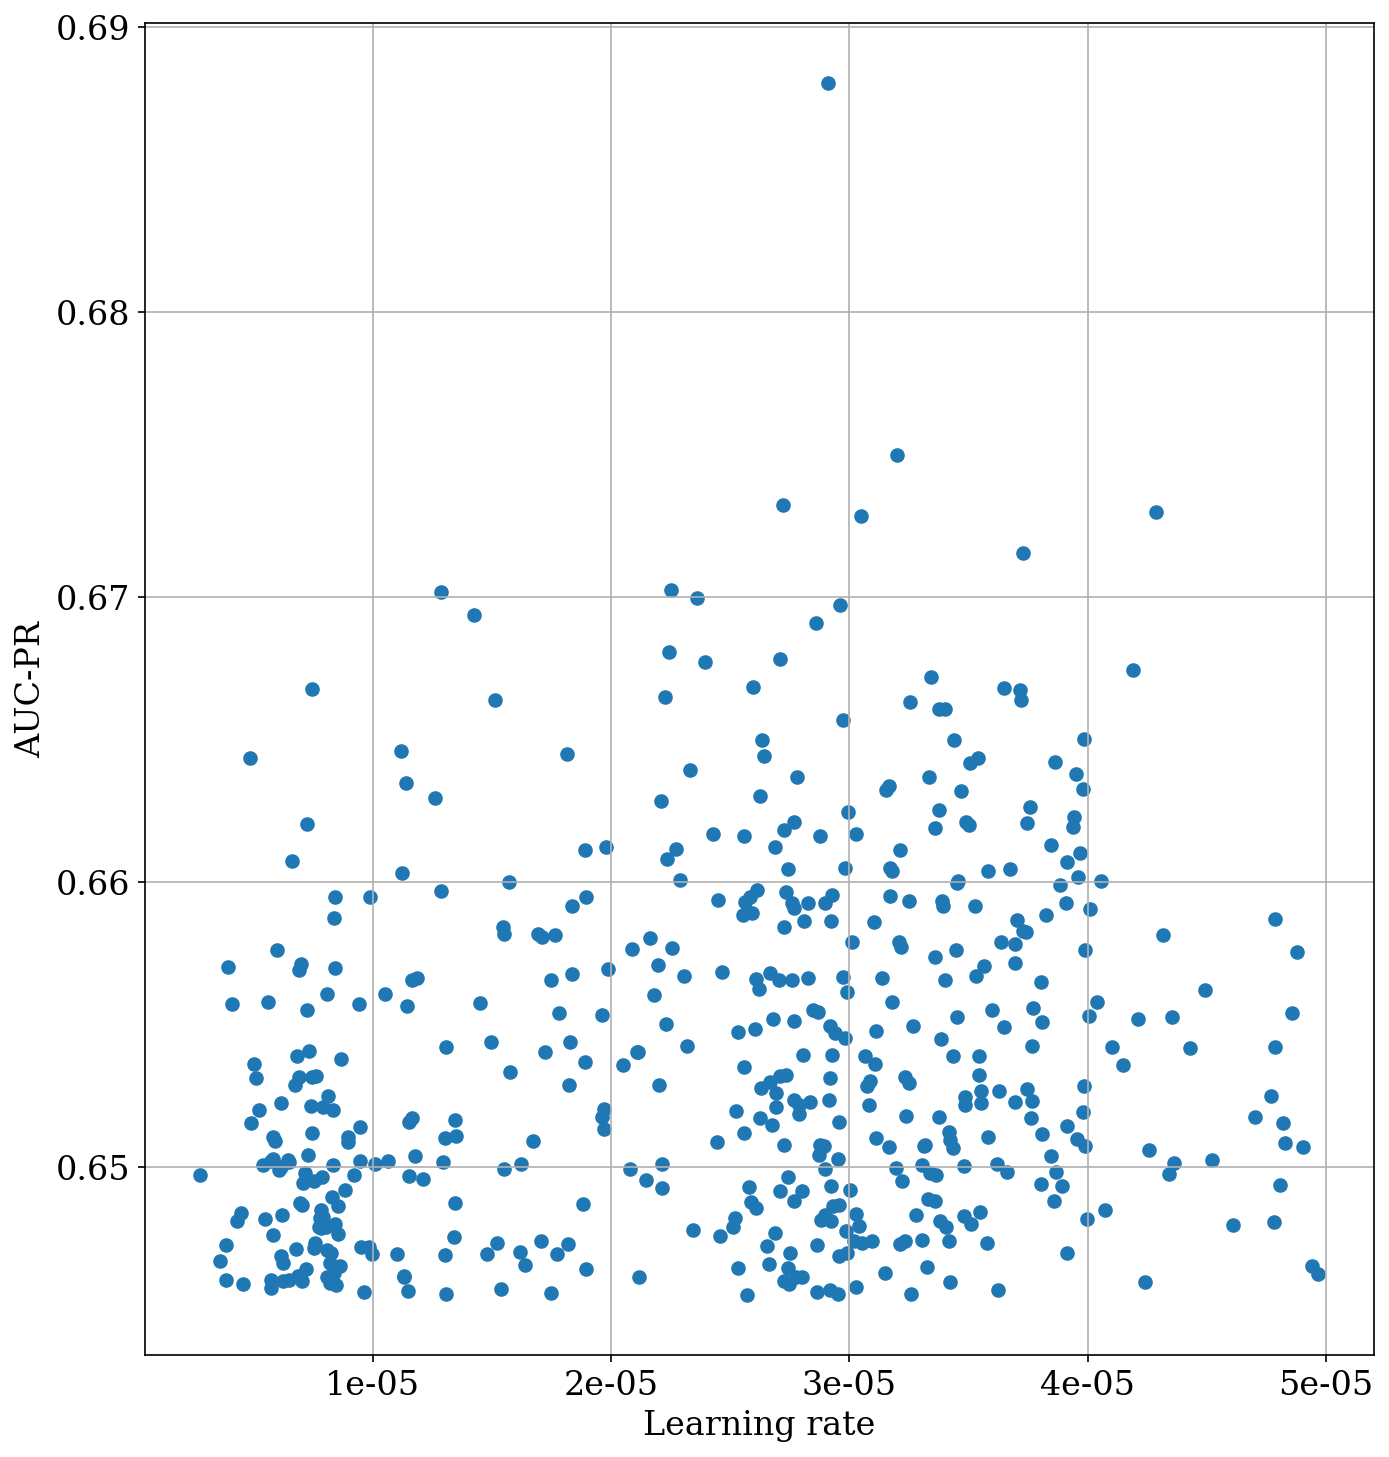

In [8]:
plt.rc('font', size=16, family=["Serif", "Palatino"])
df = pd.read_csv("/home/yassin/Downloads/wandb_export_2022-05-27T17 28 11.680+02 00.csv")
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
ax.scatter(df["lr"], df["AVG-Precision/valid"])
ax.set(xlabel="Learning rate", ylabel="AUC-PR")
ax.grid(True)
ax.xaxis.set_major_formatter(tick.FormatStrFormatter("%.0e"))
fig.tight_layout()
fig.subplots_adjust(right=0.93)


# Longformer-4096


## Positive class


In [9]:
pos = df_longf_4096[df_longf_4096["target"] == 1]
diff = (pos.target - pos.p_readmit).abs().sort_values()
top_10 = diff[:10].index
bottom_10 = diff[-10:].index

### Best


In [10]:
best = df_longf_4096.iloc[top_10[0]]

In [11]:
f"HADM_ID={best.hadm_id} PRED={best.p_readmit} TARGET={best.target}"

'HADM_ID=180749.0 PRED=0.84765625 TARGET=1.0'

In [12]:
best.tokenized[:TEXT_SIZE]

'[CLS] date of birth : sex : m service : medicine all ##er ##gies : pen ##ici ##llins / er ##yt ##hr ##omy ##cin base / st ##re ##pt ##omy ##cin / ci ##tric acid / ate ##no ##lo ##l / tor ##se ##mide / he ##par ##in agents attending : chief complaint : bleeding from col ##ost ##omy and foley major surgical or invasive procedure : none history of present illness : 84 year old male with multiple co - mor ##bid ##ities including rec ##tal cancer s / p res ##ection and radiation in now with col ##ost ##omy , corona ##ry artery disease s / p ste ##nts , sy ##sto ##lic ch ##f , dil ##ated card ##iom ##yo ##pathy , at ##rial fi ##bri ##llation not on , cardiac arrest and complete heart block s / p ai ##cd / pace ##maker , recent tr ##ach / peg after prolonged hospital ##ization for rib fractures /'

In [13]:
best_lstm = df_lstm.iloc[df_lstm.index[df_lstm["hadm_id"] == best.hadm_id][0]]

In [14]:
f"HADM_ID={best_lstm.hadm_id} PRED={best_lstm.p_readmit} TARGET={best_lstm.target}"

'HADM_ID=180749 PRED=0.8916015625 TARGET=1.0'

In [15]:
best_lstm.text[:TEXT_SIZE]

'date of birth sex m service medicine allergies penicillins / erythromycin base / streptomycin / citric acid / atenolol / torsemide / heparin agents attending chief complaint bleeding from colostomy and foley major surgical or invasive procedure none history of present illness 84 year old male with multiple co-morbidities including rectal cancer s/p resection and radiation in now with colostomy , coronary artery disease s/p stents , systolic chf , dilated cardiomyopathy , atrial fibrillation not on , cardiac arrest and complete heart block s/p aicd/pacemaker , recent trach/peg after prolonged hospitalization for rib fractures/flail chest s/p fall who presents with large amount of bleeding from colostomy and foley . the patient also endorsed increased shortness of breath , weakness and fatig'

### Worst


In [147]:
worst = df_longf_4096.iloc[bottom_10[4]]

In [148]:
f"HADM_ID={worst.hadm_id} PRED={worst.p_readmit} TARGET={worst.target}"

'HADM_ID=151523.0 PRED=0.12445068359375 TARGET=1.0'

In [149]:
worst.tokenized[:TEXT_SIZE]

'[CLS] date of birth : sex : m service : card ##iot ##hora ##cic all ##er ##gies : patient recorded as having no known all ##er ##gies to drugs attending : chief complaint : chest pain major surgical or invasive procedure : corona ##ry artery bypass graf ##ting x ##4 : left internal ma ##mma ##ry artery to left anterior descending corona ##ry ; reverse sap ##hen ##ous vein single graf ##t from ao ##rta to first ob ##tus ##e marginal corona ##ry artery ; reverse sap ##hen ##ous vein single graf ##t from ao ##rta to posterior descending corona ##ry artery ; as well as reverse sap ##hen ##ous vein graf ##t from ao ##rta to first diagonal corona ##ry artery - history of present illness : 72 year old male with ex ##ert ##ional chest discomfort with recent abnormal stress test referred for cardia'

In [150]:
worst_lstm = df_lstm.iloc[df_lstm.index[df_lstm["hadm_id"] == worst.hadm_id][0]]

In [151]:
f"HADM_ID={worst_lstm.hadm_id} PRED={worst_lstm.p_readmit} TARGET={worst_lstm.target}"

'HADM_ID=151523 PRED=0.227783203125 TARGET=1.0'

In [152]:
worst_lstm.text

"date of birth sex m service cardiothoracic allergies patient recorded as having no known allergies to drugs attending chief complaint chest pain major surgical or invasive procedure coronary artery bypass grafting x4 left internal mammary artery to left anterior descending coronary reverse saphenous vein single graft from aorta to first obtuse marginal coronary artery reverse saphenous vein single graft from aorta to posterior descending coronary artery as well as reverse saphenous vein graft from aorta to first diagonal coronary artery - history of present illness 72 year old male with exertional chest discomfort with recent abnormal stress test referred for cardiac catherization to evaluate . now asked to evaluate for surgical revascularization . past medical history hypertension hyperlipidemia gerd glaucoma gout thrombocytopenia motorcycle accident with significant bony and soft tissue damage to the right foot , s/p orif of right 5th metatarsal and i&d social history occupation ret

In [153]:
stylecloud.gen_stylecloud(worst_lstm.text, icon_name="fas fa-square")

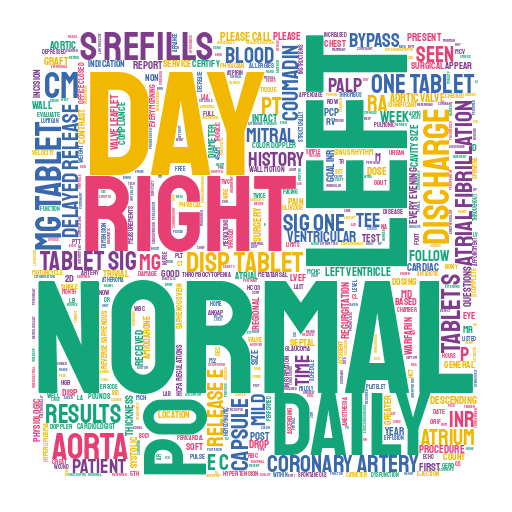

In [154]:
from IPython.display import Image
Image(filename='stylecloud.png') 